<a href="https://colab.research.google.com/github/ahmadrathore/Provisioning-SmartX-MicroBox/blob/master/4_GRU_Multivariate_Horizon_Style_FlowData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [184]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [185]:
#df = pd.read_csv(r'merge-csv.com__602f0aa73c265.csv')
#df = pd.read_csv('merge-csv.com__602f0aa73c265.csv',index_col='Processing_time',
#                infer_datetime_format=True)

url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/kafka9092_Network-Flows.csv'

df = pd.read_csv(url,index_col='Processing_time',
                infer_datetime_format=True)



In [186]:
df.head()

,Measurement_boxname,src_host_port,dest_host_port,protocol,protocol_count,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes,flow_duration
Processing_time,,,,,,,,,,,,,,,
2020-12-01T00:05:24.998+09:00,smartx-microbox-gist-1,39846,9092,6,183,2438,2439,2439,0.07,161,11888,2788.26,2591.23,510252,170.018
2020-12-01T00:10:44.861+09:00,smartx-microbox-gist-1,39846,9092,6,396,2438,2439,2439,0.11,63,11856,2228.37,2094.46,882435,290.016
2020-12-01T00:15:33.979+09:00,smartx-microbox-gist-1,39846,9092,6,395,2438,2439,2439,0.13,102,13084,2209.62,2321.09,872801,290.017
2020-12-01T00:25:41.464+09:00,smartx-microbox-gist-1,39846,9092,6,459,2438,2439,2439,0.09,61,11550,1989.66,1919.81,913254,290.017
2020-12-01T00:35:18.114+09:00,smartx-microbox-gist-1,39846,9092,6,456,2438,2439,2439,0.09,87,11544,1981.21,1909.48,903430,290.011


In [187]:
df.describe()

,src_host_port,dest_host_port,protocol,protocol_count,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes,flow_duration
count,8576.000000,8576.0,8576.0,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000
mean,40807.862873,9092.0,6.0,362.090602,2315.889576,2317.284632,2316.846782,0.317004,76.953708,10271.796525,2104.136580,2048.747845,761531.681087,279.171818
std,3907.567979,0.0,0.0,56.159077,395.897535,394.644232,395.614646,1.226467,19.597907,1867.873236,175.951136,231.740512,131589.840309,34.988489
min,33560.000000,9092.0,6.0,22.000000,499.000000,501.000000,501.000000,0.000000,59.000000,5971.000000,1387.150000,1291.840000,44072.000000,10.014000
25%,39846.000000,9092.0,6.0,340.000000,2438.000000,2439.000000,2439.000000,0.000000,62.000000,8740.000000,1973.480000,1867.347500,686703.750000,290.015000
50%,39846.000000,9092.0,6.0,369.000000,2438.000000,2439.000000,2439.000000,0.050000,69.000000,10587.000000,2094.890000,2032.635000,709585.000000,290.016000
75%,40442.000000,9092.0,6.0,398.000000,2439.000000,2439.000000,2439.000000,0.100000,88.000000,11718.000000,2226.530000,2229.402500,882164.750000,290.017000
max,59584.000000,9092.0,6.0,514.000000,2439.000000,2439.000000,2439.000000,21.950000,264.000000,14764.000000,2899.900000,2856.150000,923288.000000,290.056000


In [188]:
#df.drop_duplicates(subset=['date_time'], keep=False,inplace=True)

In [189]:
Measurement_boxname_le = preprocessing.LabelEncoder()
df['Measurement_boxname_le'] = Measurement_boxname_le.fit_transform(df['Measurement_boxname']) 

In [190]:
df = df[['std_dev_tcp_window_size','avg_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','Measurement_boxname_le','std_dev_databytes','total_data_bytes']]
#df = df[['min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']]
#df = df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']]
#df = df[['std_dev_tcp_window_size','avg_tcp_window_size','max_tcp_window_size','min_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']]


In [191]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [192]:
validate = df[['std_dev_tcp_window_size','avg_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','Measurement_boxname_le','std_dev_databytes','total_data_bytes']].tail(100)
#validate = df[['min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(100)
#validate = df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']].tail(100)
#validate = df[['std_dev_tcp_window_size','max_tcp_window_size','avg_tcp_window_size','min_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']].tail(100)
df.drop(df.tail(100).index,inplace=True)

In [193]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
#dataX = x_scaler.fit_transform(df[['Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']])
dataX = x_scaler.fit_transform(df[['std_dev_tcp_window_size','avg_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','Measurement_boxname_le','std_dev_databytes','total_data_bytes']])
#dataX = x_scaler.fit_transform(df[['std_dev_tcp_window_size','avg_tcp_window_size','max_tcp_window_size','min_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']])
#dataX = x_scaler.fit_transform(df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']])
dataY = y_scaler.fit_transform(df[['total_data_bytes']])

In [194]:
#hist_window = 250
hist_window = 250
horizon = 100
TRAIN_SPLIT = 5500
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi = custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [195]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[0.00318907 1.         0.49756098 ... 0.         0.83064738 0.53022238]
 [0.00501139 1.         0.0195122  ... 0.         0.51308245 0.95353474]
 [0.00592255 1.         0.2097561  ... 0.         0.65795782 0.94257725]
 ...
 [0.00318907 1.         0.00487805 ... 0.         0.63345501 0.96021797]
 [0.0022779  1.         0.00487805 ... 0.         0.72288741 0.94075972]
 [0.00455581 1.         0.01463415 ... 0.         0.71618158 0.93744654]]

 Target horizon
[[0.97845239]
 [0.9564851 ]
 [0.96109602]
 [0.96282483]
 [0.93314726]
 [0.9368335 ]
 [0.56987816]
 [0.97438627]
 [0.97429301]
 [0.96975715]
 [0.94493731]
 [0.94124766]
 [0.95624511]
 [0.93821427]
 [0.94459723]
 [0.94795704]
 [0.55808811]
 [0.97587282]
 [0.9508221 ]
 [0.9536826 ]
 [0.94350876]
 [0.95121449]
 [0.95460501]
 [0.94560154]
 [0.94516023]
 [0.95540459]
 [0.97044412]
 [0.54889015]
 [0.94349056]
 [0.96267129]
 [0.94383405]
 [0.96711388]
 [0.94191985]
 [0.95797051]
 [0.95396239]
 [0.95468804]
 [0.9

In [196]:
BATCH_SIZE = 256
BUFFER_SIZE = 300

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [197]:
GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=x_train_multi.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
GRU_model.compile(optimizer='adam', loss='mse')


In [198]:
model_path = r'GRU_Multivariate.h5'

In [199]:
EVALUATION_INTERVAL = 100
EPOCHS = 150
history = GRU_model.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=200,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 9s 71ms/step - loss: 0.3486 - val_loss: 0.0114
Epoch 2/150
100/100 [==============================] - 6s 64ms/step - loss: 0.0378 - val_loss: 0.0098
Epoch 3/150
100/100 [==============================] - 6s 64ms/step - loss: 0.0307 - val_loss: 0.0102
Epoch 4/150
100/100 [==============================] - 6s 64ms/step - loss: 0.0259 - val_loss: 0.0105
Epoch 5/150
100/100 [==============================] - 6s 65ms/step - loss: 0.0246 - val_loss: 0.0093
Epoch 6/150
100/100 [==============================] - 6s 64ms/step - loss: 0.0215 - val_loss: 0.0096
Epoch 7/150
100/100 [==============================] - 6s 65ms/step - loss: 0.0209 - val_loss: 0.0107
Epoch 8/150
100/100 [==============================] - 6s 65ms/step - loss: 0.0202 - val_loss: 0.0098
Epoch 9/150
100/100 [==============================] - 6s 65ms/step - loss: 0.0199 - val_loss: 0.0093
Epoch 10/150
100/100 [==============================] - 6s 65ms/step - loss: 0.018

In [200]:
Trained_model = tf.keras.models.load_model(model_path)

In [201]:
# Show the model architecture
Trained_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 250, 100)          33000     
_________________________________________________________________
dropout_12 (Dropout)         (None, 250, 100)          0         
_________________________________________________________________
gru_13 (GRU)                 (None, 50)                22800     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               5100      
Total params: 60,900
Trainable params: 60,900
Non-trainable params: 0
_________________________________________________________________


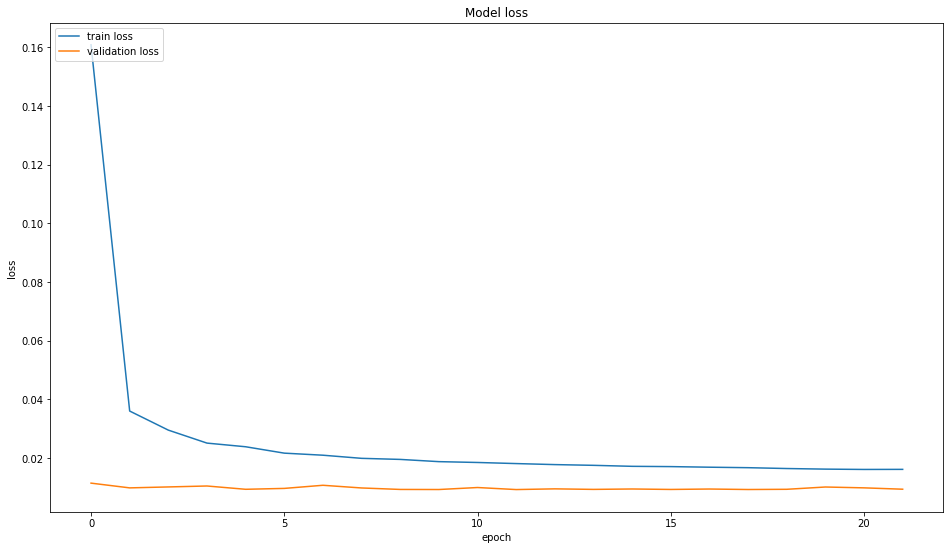

In [202]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [203]:
data_val = x_scaler.fit_transform(df[['std_dev_tcp_window_size','avg_tcp_window_size','Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']].tail(100))
#data_val = x_scaler.fit_transform(df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']].tail(100))
#data_val = x_scaler.fit_transform(df[['std_dev_tcp_window_size','avg_tcp_window_size','max_tcp_window_size','min_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']].tail(100))
#data_val = x_scaler.fit_transform(df[['Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']].tail(80))

In [204]:
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [205]:
Predicted_results = Trained_model.predict(val_rescaled)

In [206]:
Predicted_results

array([[0.76306546, 0.80214524, 0.7899816 , 0.7586981 , 0.77710915,
        0.7374229 , 0.76048195, 0.7769066 , 0.77895063, 0.7937354 ,
        0.749329  , 0.7572242 , 0.7454773 , 0.7747103 , 0.79467726,
        0.7768271 , 0.77083826, 0.7578591 , 0.7718633 , 0.74665207,
        0.7632508 , 0.74380463, 0.7935467 , 0.77626604, 0.739165  ,
        0.7233055 , 0.7377583 , 0.7516589 , 0.7749304 , 0.75596315,
        0.71999186, 0.7449764 , 0.78329533, 0.73543316, 0.7674513 ,
        0.7882379 , 0.7376792 , 0.751344  , 0.7637762 , 0.75865984,
        0.7754122 , 0.7724903 , 0.76530975, 0.752816  , 0.78050154,
        0.7726046 , 0.74423414, 0.7571933 , 0.81056374, 0.788439  ,
        0.7243459 , 0.7584262 , 0.79149455, 0.77607834, 0.7751945 ,
        0.7522799 , 0.7378611 , 0.7541946 , 0.7471726 , 0.7853339 ,
        0.7605866 , 0.790573  , 0.77534026, 0.77280796, 0.7659933 ,
        0.7854587 , 0.76467186, 0.7795376 , 0.75778973, 0.769944  ,
        0.77341515, 0.7763312 , 0.7261717 , 0.79

In [207]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [208]:
Predicted_results_Inv_trans

array([[714971.4 , 749330.94, 738636.5 , 711131.5 , 727318.8 , 692426.  ,
        712699.94, 727140.75, 728937.9 , 741936.9 , 702894.06, 709835.6 ,
        699507.6 , 725209.7 , 742765.  , 727070.8 , 721805.4 , 710393.9 ,
        722706.56, 700540.44, 715134.4 , 698036.94, 741770.94, 726577.56,
        693957.7 , 680013.8 , 692720.9 , 704942.56, 725403.25, 708726.94,
        677100.4 , 699067.2 , 732757.8 , 690676.6 , 718827.44, 737103.44,
        692651.4 , 704665.7 , 715596.25, 711097.9 , 725826.8 , 723257.9 ,
        716944.56, 705959.9 , 730301.44, 723358.3 , 698414.56, 709808.5 ,
        756732.6 , 737280.2 , 680928.56, 710892.44, 739966.7 , 726412.5 ,
        725635.44, 705488.5 , 692811.3 , 707172.  , 700998.1 , 734550.1 ,
        712791.94, 739156.44, 725763.56, 723537.1 , 717545.56, 734659.9 ,
        716383.75, 729453.94, 710332.9 , 721019.1 , 724071.  , 726634.8 ,
        682533.75, 740657.06, 699272.94, 737122.4 , 735057.4 , 679292.  ,
        732095.4 , 736912.5 , 718276.4

In [209]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [210]:
timeseries_evaluation_metrics_func(validate['total_data_bytes'],Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is : 8155777515.846562
MAE is : 60419.91625
RMSE is : 90309.3434581747
MAPE is : 10.130047894081237
R2 is : -0.05010007381988335



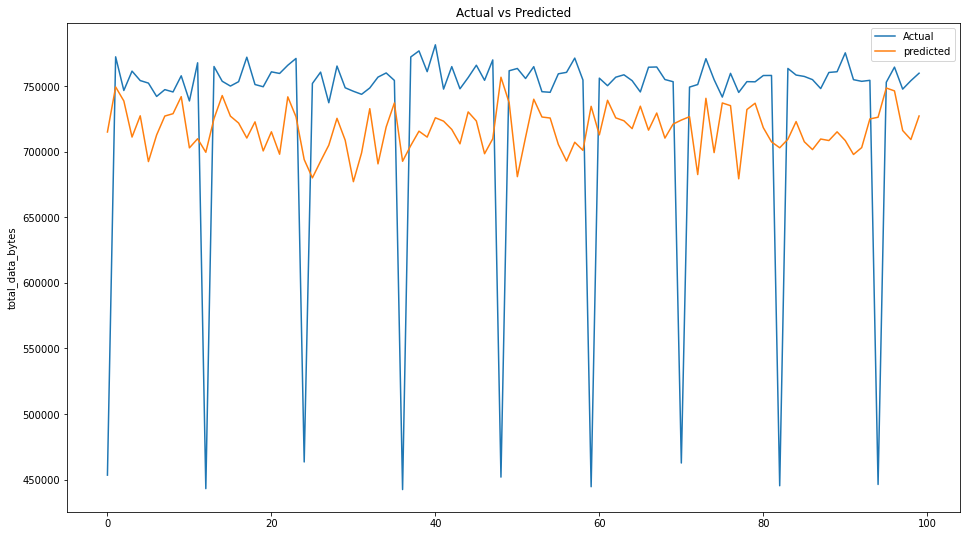

In [211]:


plt.plot( list(validate['total_data_bytes']))
plt.plot( list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("total_data_bytes")
plt.legend(('Actual','predicted'))
plt.show()
